<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Machine_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Methods**
---
Welcome to Particle Identification Playground! In this activity, you will learn about boosted decision trees and how they can be used to identify particles!

**Before attempting this notebook, complete all of the activities in the Getting Started section and the Particle Identification Methods section. Also, be sure to complete the following notebooks from the Advanced Topics section before attempting this notebook:**
*   Working with Experimental Data
*   Confusion Matrices
*   Comparing PID Methods

**After completing this notebook, you will be able to:**
*   Describe the advantages and shortcomings of manual PID methods
*   Explain the complementary advantages and disadvantages of machine learning
*   Create and train a Scikit-learn boosted decision trees model
*   Compare between the separation power of the boosted decision tree and the separation power of manual PID methods

In [18]:
#@title Run this cell before starting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as pxp
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interactive, fixed, widgets, HBox, VBox, Layout
from google.colab import output
import math
import sklearn.ensemble
output.enable_custom_widget_manager()

def format_labels(particle):
  if particle == "Photon":
    return r"$\gamma$"
  elif particle == "KLong":
    return r"$K_L$"
  elif particle == "Neutron":
    return r"$n$"
  elif particle == "Proton":
    return r"$p$"
  elif particle == "K+":
    return r"$K+$"
  elif particle == "Pi+":
    return r"$\pi+$"
  elif particle == "AntiMuon":
    return r"$\overline{\mu}$"
  elif particle == "Positron":
    return r"$\overline{e}$"
  elif particle == "AntiProton":
    return r"$\overline{p}$"
  elif particle == "K-":
    return r"$K-$"
  elif particle == "Pi-":
    return r"$\pi-$"
  elif particle == "Muon":
    return r"$\mu$"
  elif particle == "Electron":
    return r"$e$"
  else:
    return particle

def from_pdg(ptype):
  if int(ptype) == 11:
    return "Electron"
  elif int(ptype) == -11:
    return "Positron"
  elif int(ptype) == 13:
    return "Muon"
  elif int(ptype) == -13:
    return "AntiMuon"
  elif int(ptype) == 211:
    return "Pi+"
  elif int(ptype) == -211:
    return "Pi-"
  elif int(ptype) == 321:
    return "K+"
  elif int(ptype) == -321:
    return "K-"
  elif int(ptype) == 2212:
    return "Proton"
  elif int(ptype) == -2212:
    return "AntiProton"
  elif int(ptype) == 2112:
    return "Neutron"
  elif int(ptype) == 22:
    return "Photon"
  elif int(ptype) == 130:
    return "KLong"

def round_accuracies(num):
  new_num = round(num,2)
  if new_num == 0.00:
    return 0
  else:
    return new_num

def replace_None(value):
  if value is not None and len(value) != 0:
    return value
  else:
    return "No ID"

def match_hypotheses(hypotheses_initial, predictions_initial):
  try:
    predictions = predictions_initial.copy().reset_index(drop=True)
  except:
    predictions = predictions_initial
  try:
    hypotheses = hypotheses_initial.copy().reset_index(drop=True)
  except:
    hypotheses = hypotheses_initial
  if hypotheses[0] == "No ID":
    return np.random.choice(predictions)
  new_list = [predictions[i] for i in range(len(predictions)) if predictions[i] != "No ID" and predictions[i] == hypotheses[i]]
  if len(new_list) == 0:
    return "No ID"
  else:
    return np.random.choice(new_list)

def most_frequent(predictions):
  pred_ar,counts = np.unique(list(predictions),return_counts=True)
  return pred_ar[np.argmax(counts)]

class ConfusionMatrix():
  def __init__(self, estimator, df, target="Generated As", pretty_symbols=True, title="", purity=False):
    dataset = df.copy().reset_index(drop=True)
    fig, ax = plt.subplots()
    predictions = []
    identities = []
    if isinstance(df['Hypothesis'][0],np.int64) or isinstance(df['Hypothesis'][0],int):
      dataset['Hypothesis']=dataset['Hypothesis'].apply(lambda x: ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"][x])
    if isinstance(df['Generated As'][0],np.int64) or isinstance(df['Generated As'][0],int):
      dataset['Generated As']=dataset['Generated As'].apply(lambda x: ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"][x])
    predictions_full = dataset.apply(estimator,axis=1)
    nRows = len(dataset.index)
    starting_index = 0
    self.purity= purity

    """
    Because the data contains groups of hypotheses, we must make predictions in batches. The `match_hypotheses` function loops through all of the
    hypotheses and predictions in the hypothesis group, and returns the prediction that matches its respective hypothesis. If there are multiple
    predictions that match the hypothesis, a random choice is made between the matching predictions.
    """

    while starting_index < nRows - 1 :
      ending_index = starting_index + dataset['Number of Hypotheses'][starting_index]
      predictions.append(match_hypotheses(dataset['Hypothesis'][starting_index:ending_index],predictions_full[starting_index:ending_index]))
      identities.append(dataset['Generated As'][starting_index])
      starting_index = ending_index


    unique_predictions = list(set(predictions))
    unique_targets = dataset[target].unique()
    self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"] if particle in unique_predictions or particle in unique_targets]

    """
    Sets the number of ticks depedning on if the `No ID` column is included.
    """

    if "No ID" in self.categories:
      nXticks = len(self.categories)
      nYticks = len(self.categories) - 1
    else:
      nXticks = len(self.categories)
      nYticks = len(self.categories)

    """
    Creates and fills the confusion matrix based on the predictions and true identities of the particles
    """

    self.confusion_matrix = np.zeros((nYticks,nXticks))
    for i in range(len(predictions)):
      generated_index = self.categories.index(identities[i])
      identified_index = self.categories.index(predictions[i])
      self.confusion_matrix[generated_index][identified_index] += 1

    """
    Normalizes the confusion matrix. If the purity option is set, the matrix is transposed first, normalized
     along rows, and then transposed again, which is equivalent to normalization down columns. If any of the
     rows or columns did not contain any entries, we fill the elements with 0.
    """

    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    for i in range(len(self.confusion_matrix)):
      self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    np.nan_to_num(self.confusion_matrix, copy=False)

    """
    Creates and displays the confusion matrix
    """

    self.im_ = ax.imshow(self.confusion_matrix)
    self.text_ = None
    cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)
    self.text_ = np.empty_like(self.confusion_matrix, dtype=object)
    thresh = (self.confusion_matrix.max() + self.confusion_matrix.min()) / 2.0
    for i in range(nYticks):
      for j in range(nXticks):
        color = cmap_max if self.confusion_matrix[i][j] < thresh else cmap_min
        text_cm = round(self.confusion_matrix[i][j], 2)
        if float(text_cm) == float(0):
          text_cm = 0
        default_text_kwargs = dict(ha="center", va="center", color=color)
        text_kwargs = {**default_text_kwargs}
        self.text_[i][j] = ax.text(j, i, text_cm, **text_kwargs)
    display_labels = self.categories
    fig.colorbar(self.im_, ax=ax)
    if pretty_symbols:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=[format_labels(x) for x in self.categories],yticklabels=[format_labels(self.categories[i]) for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    else:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=self.categories,yticklabels=[self.categories[i] for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    ax.set_ylim((nYticks - 0.5, -0.5))
    self.figure_ = fig
    self.figure_.set_figheight(7)
    self.figure_.set_figwidth(7)
    self.ax_ = ax
    ax.set_title(title)

  @classmethod
  def from_predictions(self, labels, predictions, pretty_symbols=True,purity= False):
    self.purity = purity
    fig, ax = plt.subplots()
    if isinstance(predictions,pd.Series):
      self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"] if particle in predictions.unique() or particle in labels.unique()]
    else:
      self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron", "No ID"] if particle in list(set(predictions)) or particle in list(set(labels))]
    if "No ID" in self.categories:
      nXticks = len(self.categories)
      nYticks = len(self.categories) - 1
    else:
      nXticks = len(self.categories)
      nYticks = len(self.categories)
    self.confusion_matrix = np.zeros((nYticks,nXticks))
    for i in range(len(predictions)):
      generated_index = self.categories.index(labels[i])
      identified_index = self.categories.index(predictions[i])
      self.confusion_matrix[generated_index][identified_index] += 1
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    for i in range(len(self.confusion_matrix)):
      self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    np.nan_to_num(self.confusion_matrix, copy=False)
    self.im_ = ax.imshow(self.confusion_matrix)
    cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)
    self.text_ = np.empty_like(self.confusion_matrix, dtype=object)
    thresh = (self.confusion_matrix.max() + self.confusion_matrix.min()) / 2.0
    for i in range(nYticks):
      for j in range(nXticks):
        color = cmap_max if self.confusion_matrix[i][j] < thresh else cmap_min
        text_cm = round(self.confusion_matrix[i][j], 2)
        if float(text_cm) == float(0):
          text_cm = 0
        default_text_kwargs = dict(ha="center", va="center", color=color)
        text_kwargs = {**default_text_kwargs}
        self.text_[i][j] = ax.text(j, i, text_cm, **text_kwargs)
    display_labels = self.categories
    fig.colorbar(self.im_, ax=ax)
    if pretty_symbols:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=[format_labels(x) for x in self.categories],yticklabels=[format_labels(self.categories[i]) for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    else:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=self.categories,yticklabels=[self.categories[i] for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    ax.set_ylim((nYticks - 0.5, -0.5))
    self.figure_ = fig
    self.ax_ = ax
    self.figure_.set_figheight(7)
    self.figure_.set_figwidth(7)
    return self

  @classmethod
  def from_model(self, model, df, target="Generated As", pretty_symbols=True, title="", purity=False):
    dataset = df.copy().reset_index(drop=True)
    fig, ax = plt.subplots()
    predictions = []
    identities = []
    raw_predictions = model.predict(dataset.drop([target],axis=1))
    if isinstance(raw_predictions[0], np.int64) or isinstance(raw_predictions[0], int):
      predictions_full = [["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"][i] for i in raw_predictions]
    else:
      predictions_full = raw_predictions
    if isinstance(df['Hypothesis'][0],np.int64) or isinstance(df['Hypothesis'][0],int):
      dataset['Hypothesis']=dataset['Hypothesis'].apply(lambda x: ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"][x])
    if isinstance(df['Generated As'][0],np.int64) or isinstance(df['Generated As'][0],int):
      dataset['Generated As']=dataset['Generated As'].apply(lambda x: ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"][x])
    nRows = len(dataset.index)
    starting_index = 0
    self.purity= purity
    while starting_index < nRows - 1 :
      ending_index = starting_index + dataset['Number of Hypotheses'][starting_index]
      predictions.append(most_frequent(predictions_full[starting_index:ending_index]))
      identities.append(dataset['Generated As'][starting_index])
      starting_index = ending_index
    unique_predictions = list(set(predictions))
    unique_targets = list(set(identities))
    self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"] if particle in unique_predictions or particle in unique_targets]
    if "No ID" in self.categories:
      nXticks = len(self.categories)
      nYticks = len(self.categories) - 1
    else:
      nXticks = len(self.categories)
      nYticks = len(self.categories)
    self.confusion_matrix = np.zeros((nYticks,nXticks))
    for i in range(len(predictions)):
      generated_index = self.categories.index(identities[i])
      identified_index = self.categories.index(predictions[i])
      self.confusion_matrix[generated_index][identified_index] += 1
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    for i in range(len(self.confusion_matrix)):
      self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    np.nan_to_num(self.confusion_matrix, copy=False)
    self.im_ = ax.imshow(self.confusion_matrix)
    self.text_ = None
    cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)
    self.text_ = np.empty_like(self.confusion_matrix, dtype=object)
    thresh = (self.confusion_matrix.max() + self.confusion_matrix.min()) / 2.0
    for i in range(nYticks):
      for j in range(nXticks):
        color = cmap_max if self.confusion_matrix[i][j] < thresh else cmap_min
        text_cm = round(self.confusion_matrix[i][j], 2)
        if float(text_cm) == float(0):
          text_cm = 0
        default_text_kwargs = dict(ha="center", va="center", color=color)
        text_kwargs = {**default_text_kwargs}
        self.text_[i][j] = ax.text(j, i, text_cm, **text_kwargs)
    display_labels = self.categories
    fig.colorbar(self.im_, ax=ax)
    if pretty_symbols:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=[format_labels(x) for x in self.categories],yticklabels=[format_labels(self.categories[i]) for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    else:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=self.categories,yticklabels=[self.categories[i] for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    ax.set_ylim((nYticks - 0.5, -0.5))
    self.figure_ = fig
    self.figure_.set_figheight(7)
    self.figure_.set_figwidth(7)
    self.ax_ = ax
    ax.set_title(title)

def split_df(input_df, training_fraction=0.9):
  if round(training_fraction,2) == 1.:
    raise ValueError("Cannot create split dataset with such a large training fraction. Reduce the training fraction.")
  df = input_df.copy().reset_index(drop=True)
  every_n_events = int(round(training_fraction/(1-training_fraction)) + 1)
  nRows = len(df.index)
  starting_index = 0
  training_list = []
  test_list = []
  index_list = []
  counter = 0
  while starting_index < nRows - 1 :
    counter += 1
    ending_index = starting_index + df['Number of Hypotheses'][starting_index]
    if counter % every_n_events == 0:
      test_list.extend([True for _ in range(starting_index, ending_index)])
      training_list.extend([False for _ in range(starting_index, ending_index)])
    else:
      test_list.extend([False for _ in range(starting_index, ending_index)])
      training_list.extend([True for _ in range(starting_index, ending_index)])
    starting_index = ending_index
  test = df.loc[test_list].reset_index(drop=True)
  training = df.loc[training_list].reset_index(drop=True)
  return training, test

def replace_empty(old):
  if len(old) == 0:
    return "No ID"
  else:
    return old

!wget -q -O particle_data.hdf5 https://github.com/duberii/pid-playground/raw/main/data/particle_data.hdf5
particle_data = pd.read_hdf("particle_data.hdf5")
particle_data['Hypothesis'] = particle_data['Hypothesis']
!wget -q -O low_momentum_particle_data.hdf5  https://github.com/duberii/pid-playground/raw/main/data/low_momentum_particle_data.hdf5
low_momentum_particle_data = pd.read_hdf("low_momentum_particle_data.hdf5")

---
##**Manual PID**
---
So far, we have explored "manual" (cuts-based) PID methods. These methods are amazing because they are intuitive. We can understand exactly why they work and what information we are using to identify particles. For example, when we are using time of flight cuts, we know that different particles should have different times of flight because at the same momentum, heavier particles will move slower. Similarly, we have an equation that tells us that the ionization energy loss of a particle is related to its velocity, which allows us to classify particles based on momentum. Because we understand exactly how these PID methods work, we can optimize our detectors to better identify particles. For example, to improve time of flight detectors, we know that we should increase our average path length.

However, we can't be certain that the cuts that we make are the best possible way to use the data provided by the detector. Maybe there is some complicated way to combine ionization energy loss and time of flight to identify particles with over 90% accuracy. It is fairly difficult to look for these types of connections between PID methods, but this is where machine learning can help us.

---
##**Machine Learning**
---
Machine learning is the process of a computer studying a specific problem and trying to learn how to solve it. In our case, the computer would study the PID problem, and will try to use the data we provide from the detector to identify particles. However, we won't tell it about all of the manual PID methods we have- it needs to figure them out on its own!

Because the computer needs to figure out its own way to identify particles based on the data we provide, it is much more likely that it will find complicated connections between data used for different PID methods. However, this comes at a cost: Computers don't tell us what they are doing. Unlike cuts-based PID methods, it is almost impossible to understand exactly how the computer is classifying particles based on the data we give it. This makes it difficult to optimize our detectors, since we don't know what changes to our detector will improve the performance of the computer. In some sense, machine learning trades explainability for accuracy.

**Explainability** is the ability for us to identify exactly why a particle was identified the way it was. With cuts, we have very explicit conditions for a particle to be identified a certain way. For example, we could say a particle was identified as an electron because its measured time of flight was extremely close to the calculated time of flight for an electron hypothesis. Explainability is extremely useful for improving our cuts and for identifying what parts of our detectors can be improved. However, if our goal is to maximize the accuracy of our PID based on the data provided by our current detector, machine learning is an extremely powerful tool.



---
##**Decision Trees**
---
There are different ways that a computer can approach solving a problem. These different approaches are called **models**. One such model is a **neural network**, which tries to solve problems using the same general structure as a human brain. Neural networks are the most famous machine learning models, but they are a bit of an overkill for the type of problem we want to solve. The model that we will use is called a **boosted decision trees** model, and it loosely tries to copy cuts-based PID.

Before we talk about boosted decision trees, let's talk about normal decision trees. A normal decision tree is truly just a series of cuts. For example, in a previous notebook, we implemented the following PID function:

In [ ]:
def identify_particle(particle):
  if particle['E'] > 0.7:
    return "Photon"
  elif particle['E'] > 0.4:
    return "KLong"
  else:
    return "Neutron"

A decision tree is just another way to visualize these cuts. The corresponding decision tree for the PID function above is:

![A diagram of a decision tree. The top node contains the unidentified particles. There are then two branches, one labeled E greater than 0.7, and the other labeled E less than or equal to 0.7. The branch with E greater than 0.7 leads to the photon "leaf" of the tree, meaning the particle will be identified as a photon if its energy is larger than 0.7 GeV. The other branch leads to another node, which also has two branches. If the energy is greater than 0.4, the branch leads to the KLong "leaf", and if the energy is less than or equal to 0.4, the branch leads to the neutron "leaf".](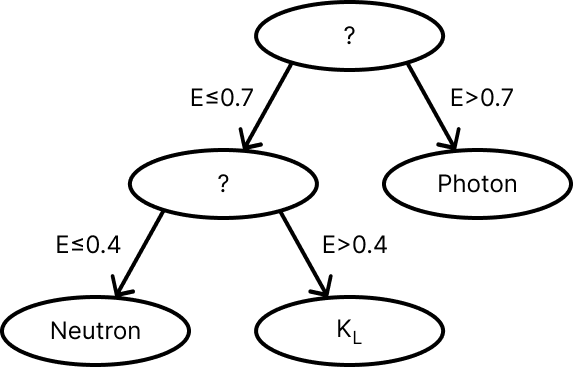)

To read this, you would start at the top circle, which is called a **node**. Pointing away from the node are two **branches**, which we will follow if the condition holds. For example, we would travel down the branch to the right if the energy of our particle is greater than 0.7 GeV. In this case, we arrive at a **leaf** labeled photon, which tells us that this decision tree identified that particle as a photon. If the energy of the particle is less than or equal to 0.7 GeV, then we travel down the other branch emerging from the top node, which leads us to another node. At this node, we have two more branches. If the energy of our particle is less than or equal to 0.4 GeV, then we reach the neutron leaf. If the energy is greater than 0.4 GeV, then we reach the KLong leaf.

In summary, all of the ovals with question marks in them are nodes, and they represent branching points in the decision tree. Which nodes we look at depend on the branches, which provide conditions for us to travel down to the next node. The leaves are where our classification is. If we reach a leaf, then our particle is labeled by the decision tree as that kind of particle.

In some sense, each branch is a cut that the model is placing on our particle. How does the machine learning model figure out what cut is best? That's where training comes in.

---
##**Training**
---
To get our machine learning models to learn to solve a complicated problem, we need to train it. Training is slightly different for every model, but because we will be working with boosted decision trees, we will walk through the process of training decision trees.

Decision trees are grown from the top to the bottom. At each node, the model tests out all possible cuts that can be made of the provided data, trying to find the best possible cut. It then implements this cut and creates two new branches, which may lead to either a leaf or another node. If it leads to another node, the model tests out all possible cuts for that new node to try and find the best cut for the new node. This process repeats until all branches end in a leaf, at which point the tree is finished.

How does it know which cut is best?  The answer is that it ranks how good each possible cut is based on a **loss function**. A loss function is a function used to calculate how good our model is doing at classifying particles. There are tons of different loss functions that we can use, but for our purposes, it doesn't really matter. All we need to know is that the lower the loss, the better our model is doing.

---
##**Boosting**
---
Where does the "boosted" part of "boosted decision trees" come in? To answer this question, we need to talk about what a boosted decision trees model is.

A boosted decision trees model is a collection of decision trees that learn to correct the mistakes of the other decision trees. These decision trees are trained sequentially, meaning the next one is trained after the previous one finishes training. This allows us to tell the next decision tree what mistakes the first one made, which will hopefully allow it to predict and correct the mistakes of the previous tree. To make a prediction, we provide the particle information to all of the trees, and we combine the predictions of all of the trees to find the best possible prediction.

---
##**Boosted Decision Trees in TensorFlow**
---
To create our boosted decision trees model, we will use a Python package called Scikit-learn (`sklearn` for short), which includes tools for machine learning in Python. The process of creating and training a machine learning model can be broken down into several steps.

---
###**Step #1: Creating Training and Test Data**
---
Before we create and train our model, we will need to create a dataset that we will use to train our model. However, once we are done training our model, we will want to test how well it works, so we usually set aside part of our data as a "test" dataset.

####**Question #1:**
---
Before working with our model, we will make a small change to the way the data is formatted to make the behavior of our model more predictable. The process of modifying our data to make it work well with a model is called **preprocessing**.

In particular, we have multiple columns that contain strings: our `Hypothesis` column and our `Generated As` column. However, machine learning models in general do not accept string inputs. We have to convert our strings into numbers. To do this, we will create a list of all of the particles we expect to see, then we will replace all of the strings in the dataframe with the index of the same string in our list. This way, we can use the list to convert back and forth between numbers (which are compatible with the machine learning model) and strings (which are easier to interpret).

Complete the cell below to use the `particle_list` to replace the `Hypothesis` column strings with numbers. The code for the `Generated As` column is completed for you.

In [ ]:
particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]
particle_data['Generated As'] = particle_data['Generated As'].apply(particle_list.index)
particle_data['Hypothesis'] = #complete this code

#####**Solution:**

In [2]:
particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]
particle_data['Generated As'] = particle_data['Generated As'].apply(particle_list.index)
particle_data['Hypothesis'] = particle_data['Hypothesis'].apply(particle_list.index)

####**Question #2:**
---
Our data is currently stored in a dataframe called `particle_data`. However, we want to split this dataframe into a training dataframe and a test dataframe. We can use the `split_df` function as follows:
```
training_df, test_df = split_df(dataframe_to_split, training_fraction = 0.9)
```
where `dataframe_to_split` is the dataframe we are trying to split and `training_fraction` refers to the fraction of events that we want to include in the training dataframe. The training dataframe is usually much larger than the test dataframe, but there is no exact fraction that you need to use. In this example, we put 90% of the data in the training dataframe and 10% of the data in the test dataframe.

Complete the code in the cell below to split the `particle_data` dataframe such that 80% of the events are included in the training dataframe, and the remaining 20% of the events are included in the test dataframe.

In [ ]:
training_df, test_df = split_df(#complete this code

#####**Solution:**

In [3]:
training_df, test_df = split_df(particle_data, training_fraction = 0.8)

---
###**Step #2: Creating a Model**
---
We can now create our boosted decision trees model! To do this, we will use Scikit-learn's (`sklearn`) `sklearn.enseble.HistGradientBoostingClassifier`. It can be used as follows:

```
model = sklearn.enseble.HistGradientBoostingClassifier()
```
However, there are tons of optional arguments we can change. Take a look at the table below to see how you can change various properties of the model.


*   **max_iter**
  *  The maximum number of boosting steps to perform. This is not exactly the number of trees. The maximum number of trees is actually equal to the number of "classes" (in our case, these are the 13 particles) times the number of iterations. The default value is 100, so by default, this will create $13*100=1300$ trees. In general, increasing this value will increase the accuracy of your model, but will also increase the time it takes to train your model. We will discuss some other downsides of increasing this number too much in later notebooks.
*   **max_leaf_nodes**
  *   The maximum number of leaves we will allow for each tree. The default value is 31, meaning each tree can consider at most 31 outcomes. It may seem strange to have more leaves than classes (particle types), but multiple leaves can belong to the same particle. For example, a single decision tree may have 2 (or more) leaves for protons.
*   **max_depth**
  *   The maximum number of nodes you want in a single branch. This limits how "big" each of your decision trees will be. In general, increasing the max depth of your trees will improve performance, but will also greatly slow down the training process. The default value is `None`, meaning that the branches can grow as large as they want, as long as the total number of leaves isn't bigger than `max_leaf_nodes`.
*   **verbose**
  *   The level of information you want the model to provide you with during training. A verbosity of `0` will not print out any information as the model is training. Any verbosity greater than `0` will print out minor details, such as the loss at each training stage, the number of trees trained, the depth of each tree, and the amount of time it took to train that tree. The default value is `0`, meaning the model will train without printing anything. Changing this value is good for monitoring the progress of your training, but the output can be quite long.

####**Question #3:**
---
Complete the code in the cell below to create a gradient boosted decision trees model with the default properties.

**Hint:** No need to provide any arguments to the function if you are fine with the default properties.

In [ ]:
model = #Complete this code

#####**Solution:**

In [4]:
model = sklearn.ensemble.HistGradientBoostingClassifier()

---
###**Step #3: Training the Model**
---
We are finally ready to train the model! If we have our model stored in a variable `model`, we can train it as follows:
```
model.fit(unlabeled_data, labels)
```
If we haven't changed our verbosity when creating the model, this line of code won't give us any output. However, if you look to the left of the cell, you will be able to see if it is still running or not.

####**Question #4:**
---
Before we train our model, we need to separate the labels from the training data. As a reminder, the labels for the `training_df` dataframe are stored in the `Generated As` column.

Complete the code below to access the labels of the dataframe (using indexing) and create an unlabeled dataset by dropping the `Generated As` column of the dataframe.

**Note:** You can drop a column from a dataframe using the `drop` method of the dataframe object. For example, `df.drop(['E'], axis=1)` would drop the column `E` from the `df` dataframe. This method creates a copy of the dataframe by default, so the dataframe stored in the variable `df` isn't changed.

In [ ]:
labels = #complete this code
unlabeled_data = #complete this code

#####**Solution:**

In [5]:
labels = training_df['Generated As']
unlabeled_data = training_df.drop(['Generated As'], axis=1)

####**Question #5:**
---
Using the labels and the unlabeled data from the previous question, complete the code below to train the model you created in Question #3.

**Note:** This will take a few minutes to run.

In [ ]:
model.fit(#complete this code)

#####**Solution:**

In [6]:
model.fit(unlabeled_data, labels)

HistGradientBoostingClassifier()

---
###**Step #4: Testing the Model**
---
As we saw in the previous section, it's hard to tell how good our model is based on training alone. If we make our model verbose, we get some information about the loss at each step, but we don't really care about loss- we care about accuracy! In this section, we will create a confusion matrix from our test data, which will give us a better idea of how powerful our model is as a PID tool.

####**Question #6:**
---
To identify particles in real data, we want to be able to make a prediction based on a single row in a dataframe. To do this, we can use the `predict` method of the model object. The general syntax is:

```
predictions = model.predict(dataframe)
```

The dataframe must be unlabeled to match the format used for training.
In the cell below, complete the code to identify the particle in the row with index 0 of the `test_df` dataframe.

**Hint:** The `test_df` dataframe has a `Generated As` column. Drop it before you use the `predict` method.

In [ ]:
particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]

unlabeled_data = #complete this code

predictions = model.predict(#complete this code

#Notice how we access the 0th element of the predictions list, since we want to access the prediction corresponding to the 0th row.
#Also, the prediction is a number (test this out by printing out the prediction directly), so we must convert it into a label by indexing the particle_list
print(particle_list[predictions[0]])

#####**Solution:**

The first few rows in our dataset represent photons, so it's good that the prediction is a photon!

In [15]:
particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]

unlabeled_data = test_df.drop(['Generated As'], axis=1)

predictions = model.predict(unlabeled_data)

#Notice how we access the 0th element of the predictions list, since we want to access the prediction corresponding to the 0th row.
#Also, the prediction is a number (test this out by printing out the prediction directly), so we must convert it into a label by indexing the particle_list
print(particle_list[predictions[0]])

Photon


####**Question #7:**
---
To create a confusion matrix from a trained model, we can use the `.from_model` method of the `ConfusionMatrix` object. The general syntax for the `from_model` method is:
```
ConfusionMatrix.from_model(model, test_dataframe)
```

Complete the code in the cell below to create a confusion matrix based on the `test_df` dataframe and the model you trained in Question #5.

In [ ]:
ConfusionMatrix.from_model(#Complete this code

#####**Solution:**

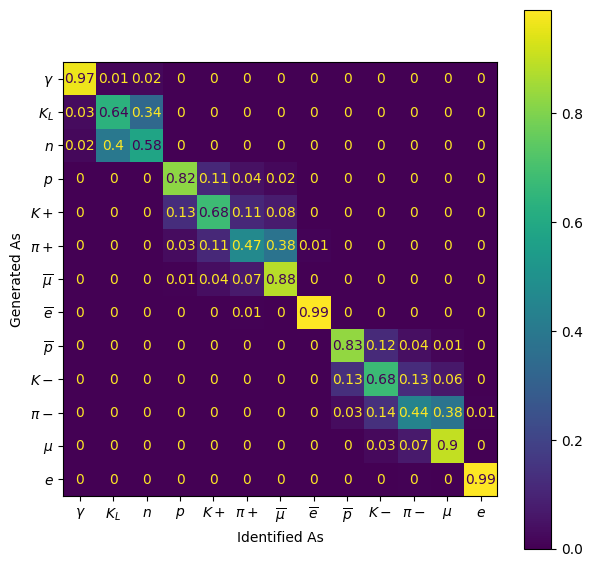

In [7]:
ConfusionMatrix.from_model(model, test_df)

####**Question #8:**
---
Below are three confusion matrices you created using ionization energy loss, time of flight, and machine learning. Based on these confusion matrices, which particles experience the greatest increase in accuracy using machine learning?

Double click to edit this cell and answer the following question: Which particles experience the greatest increase in accuracy using machine learning?

#####**Time of Flight:**

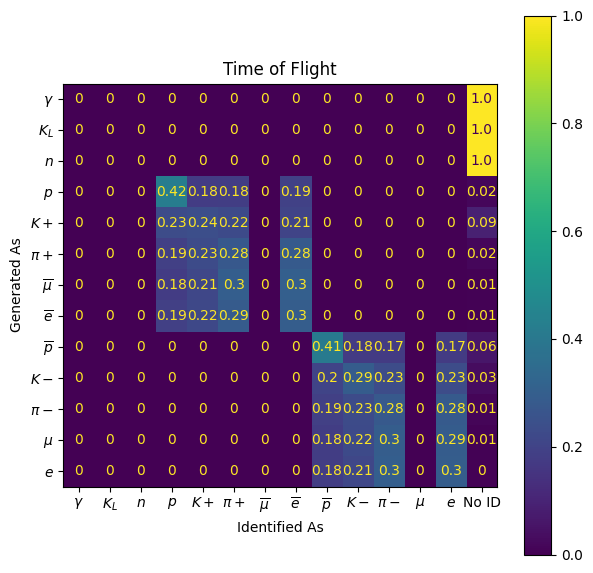

In [10]:
# @title
def TOF_Proton(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Kaon(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Pion(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Electron(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def Combined_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(Combined_TOF, test_df, title="Time of Flight")

#####**Ionization Energy Loss:**

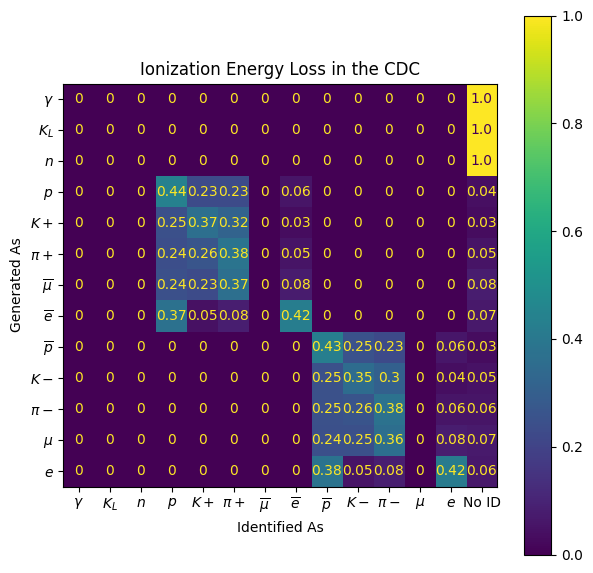

In [11]:
# @title
def dEdx_CDC_Proton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-2.5*p+2.3)+1.4:
    return True
  else:
    return False

def dEdx_CDC_Kaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-4.9*p+2.3)+1.45 and particle['CDC dEdx'] *10**6< np.exp(-4.36*p+2.3)+2.3:
    return True
  else:
    return False

def dEdx_CDC_Pion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> 1.59 and particle['CDC dEdx'] *10**6< 2.49:
    return True
  else:
    return False

def dEdx_CDC_Electron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> 2.25 and particle['CDC dEdx'] *10**6< 3.14:
    return True
  else:
    return False

def dEdx_CDC(particle):
  if particle['Hypothesis'] == "Proton" and dEdx_CDC_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and dEdx_CDC_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and dEdx_CDC_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and dEdx_CDC_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and dEdx_CDC_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and dEdx_CDC_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and dEdx_CDC_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and dEdx_CDC_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(dEdx_CDC, test_df, title="Ionization Energy Loss in the CDC")

#####**Machine Learning:**

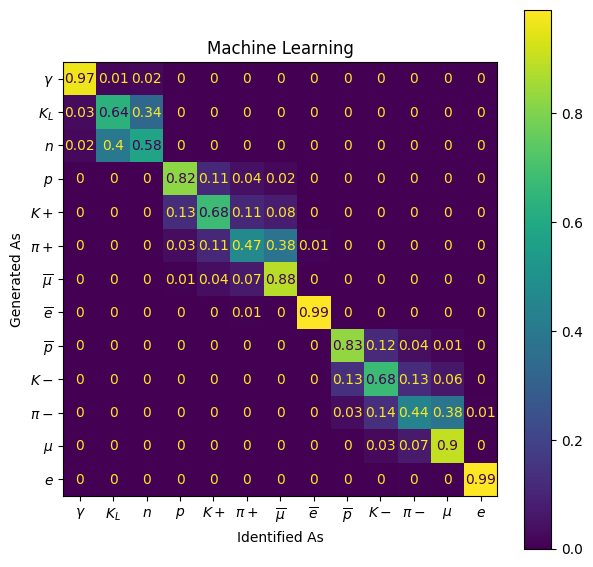

In [12]:
# @title
ConfusionMatrix.from_model(model, test_df, title="Machine Learning")

#####**Solution:**

The particles that see the greatest improvement in accuracy are the ones that are not included in cuts-based PID, such as photons, KLongs, neutrons, and muons. However, all particles (except pions) see a significant increase in accuracy. Protons and antiprotons go from about 40% accuracy using cuts-based PID to over 80% accuracy using machine learning PID. Kaons go from 20-30% accuracy using cuts-based PID to 68% accuracy using machine learning PID. Pions don't experience a significant increase in accuracy using machine learning, but this is because pions and muons are extremely difficult to identify without dedicated detectors (which GlueX does not have). However, if we combine the muon and pion categories, we see that a pion or a muon is identified as either a pion or a muon with over 80% accuracy (which we can see by just taking the sum of the pion and muon column). Finally, electrons and positrons can be identified with over 99% accuracy using machine learning PID.

####**Question #9:**
---
The `low_momentum_particle_data` dataframe contains hypotheses for particles that were generated with under 1 GeV/c in momentum. In contrast, the `particle_data` dataframe we have worked with so far has contained particles generated with under 5 GeV/c in momentum. Write code in the cell below to train a model based on this new dataset, then create a confusion matrix using any test data you set aside. Finally, answer the following question: Are particles easier to identify at larger momenta or lower momenta?

**Hint:** Follow the steps outlined above, just with the new dataframe.

**Note:** If you need to run this cell multiple times, remove the lines of code in which you replace the strings with numbers (using the `index` method), as these will cause an error if the columns already contain numbers.

Double click to edit this cell and answer the following question: Are particles easier to identify at larger momenta or lower momenta?

In [ ]:
#Complete this code

#####**Solution:**

Based on the confusion matrix below, it is easier to identify particles at lower momenta. Photons are identified with approximately 100% accuracy (though it's impossible to guarantee that every single low-momentum photon will be accurately identified), and every particle (except for pions, which are frequently confused for muons and KLongs, which are extremely difficult to identify in general) can be identified with over 90% accuracy.

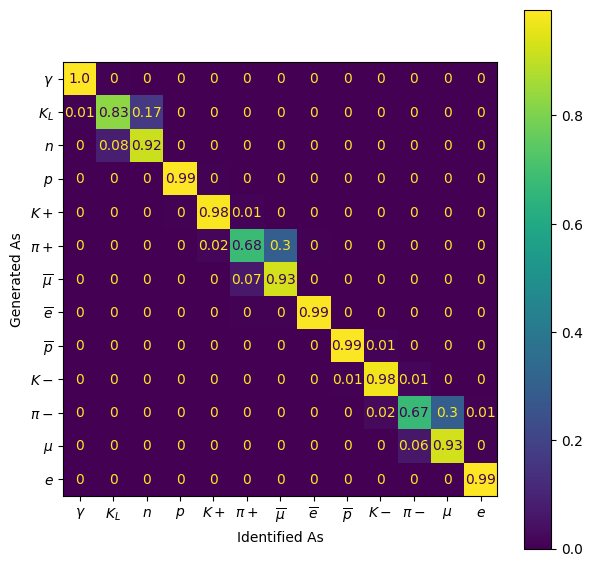

In [19]:
particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]

low_momentum_particle_data['Generated As'] = low_momentum_particle_data['Generated As'].apply(particle_list.index)
low_momentum_particle_data['Hypothesis'] = low_momentum_particle_data['Hypothesis'].apply(particle_list.index)

training, test = split_df(low_momentum_particle_data, training_fraction = 0.8)

low_momentum_model = sklearn.ensemble.HistGradientBoostingClassifier()

labels = training['Generated As']
unlabeled_data = training.drop(['Generated As'], axis=1)

low_momentum_model.fit(unlabeled_data, labels)

ConfusionMatrix.from_model(low_momentum_model, test)